In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
stock_df_raw = pd.read_sql(query_stock, engine)


結論
只要有上市櫃股票 

當天開盤買 放到收盤 黑K就出掉

只要不是收跌 就抱著 
1. 抱到第八天收盤賣
2. 抱到跌破第一天開盤價往下3%賣掉
3. 回測若獲利大於20%繼續抱

https://www.twse.com.tw/zh/listed/listed/apply-listing.html

https://www.tpex.org.tw/web/regular_emerging/apply_schedule/applicant/applicant_companies.php?l=zh-tw



In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')


# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame

sub_category_list = pd.read_sql(query_sub_category, engine)



In [42]:
# 先找上市第一筆
import numpy as np
import warnings
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2021-06-01') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['loss_pen','cumsum1','cumsum2','len'])

hold_day = 7 # 7
loss_pen_list = np.arange(0.96, 0.97, 0.01)
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0

for loss_pen in loss_pen_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day1Diff','Day8收盤價','Day11收盤價','Day85MA','earn1','earn2','loss_price','loss_type'])
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        # new_stock = new_stock_df[new_stock_df['證券代號'] == stock_id]
        new_stock = new_stock.head(hold_day+1)
        if (len(new_stock) == hold_day+1):
            loss_price = 0
            loss_type = '0'
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]

            day1_diff = day1_close_price - day1_open_price

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day] # 第八天
            MA5 = new_stock['5MA'].iloc[hold_day] 
            close_price_20 = 0
            # close_price2 = new_stock['收盤價'].iloc[hold_day+1]
            # close_price3 = new_stock['收盤價'].iloc[10]

            # 1. 直接放五天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            # 2. 第一天收黑就不要了，其他的放五天
            if (day1_diff < 0):
                loss_type = '1'
                loss_price = day1_close_price
                earn2 =  100 * (loss_price-day1_open_price)/day1_open_price
            else :
                loss_data = new_stock[new_stock['收盤價'] < day1_open_price * loss_pen]

                # 盤中最低價跌破停損
                # loss_data = new_stock[(new_stock['最低價'] < day1_open_price*0.95) & (new_stock['收盤價'] != day1_close_price) ]

                if(len(loss_data) > 0):
                    loss_type = '2'
                    loss_price = loss_data['收盤價'].iloc[0]
                    earn2 = 100 * (loss_price - day1_open_price)/day1_open_price
                else:
                    loss_type = '3'
                    earn2 = 100 * (close_price - day1_open_price)/day1_open_price

                    # # 賺超過 20%
                    # if (earn2 > 20):
                    #     loss_type = '4'

                    #     close_price_20 = new_stock['收盤價'].iloc[hold_day+3]
                    #     earn2 = 100 * (close_price_20 - day1_open_price)/day1_open_price
                        


            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1收盤價': [day1_close_price],
                'Day1Diff':[day1_diff],
                'Day8收盤價': [close_price],
                'Day11收盤價' : [close_price_20],
                'Day85MA': [MA5],
                'earn1': [earn1],
                'earn2': [earn2],
                'loss_price':[loss_price],
                'loss_type':[loss_type]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()

    temp_df = pd.DataFrame({
        'loss_pen': [loss_pen],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'len' : [len(new_stock_list)]
    })

    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list

,loss_pen,cumsum1,cumsum2,len
0,0.96,445.175616,596.921437,144
1,0.97,445.175616,631.223227,144


In [28]:
new_stock_list_4 = new_stock_list[new_stock_list['loss_type'] == '4']

sum(100 * ((new_stock_list_4['Day11收盤價']/new_stock_list_4['Day8收盤價']) -1))

new_stock_list_4

,Date,證券代號,證券名稱,Day1開盤價,Day1收盤價,Day1Diff,Day8收盤價,Day11收盤價,Day85MA,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
0,2021-05-31,2250,IKKA-KY,152.0,159.0,7.0,189.50,189.0,181.50,24.671053,24.671053,0,4,24.671053,24.671053
8,2021-10-25,5222,全訊,160.0,181.0,21.0,207.50,194.0,195.40,29.687500,29.687500,0,4,-17.839806,19.200942
9,2021-11-08,6761,穩得,154.0,165.0,11.0,216.50,202.0,210.30,40.584416,40.584416,0,4,22.744610,59.785358
33,2022-05-12,6799,來頡,151.0,153.0,2.0,193.00,202.0,198.80,27.814570,27.814570,0,4,9.924049,61.204828
47,2022-09-08,3430,奇鈦科,54.3,59.1,4.8,72.00,72.9,65.78,32.596685,32.596685,0,4,6.541050,83.652834
55,2022-11-21,6843,進典,40.5,45.3,4.8,49.55,49.2,51.63,22.345679,22.345679,0,4,2.852115,107.395390
56,2022-11-28,6782,視陽,245.5,260.0,14.5,336.50,331.0,315.90,37.067210,37.067210,0,4,39.919325,144.462600
60,2022-12-15,6517,保勝光學,50.6,64.0,13.4,66.00,59.5,66.06,30.434783,30.434783,0,4,72.598895,186.606798
64,2023-03-01,6841,長佳智能,98.6,110.5,11.9,134.00,117.5,124.10,35.902637,35.902637,0,4,84.120823,214.567165
65,2023-03-06,6873,泓德能源-創,121.0,121.0,0.0,157.50,152.5,147.10,30.165289,30.165289,0,4,114.286112,244.732454


In [174]:
new_stock_list[new_stock_list['證券代號'] == '6914']

,Date,證券代號,證券名稱,Day1開盤價,Day1收盤價,Day1Diff,Day8收盤價,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
121,2024-05-03,6914,阜爾運通,198.0,188.5,-9.5,194.0,-2.020202,-4.79798,188.5,1,297.318049,432.816921


In [184]:
new_stock_list[new_stock_list['loss_type'] == '1'].sort_values(by='earn2', ascending=True).head(40)[['Date', '證券名稱','Day1開盤價', 'Day1收盤價','loss_price','Day8收盤價','earn2','loss_type']]


,Date,證券名稱,Day1開盤價,Day1收盤價,loss_price,Day8收盤價,earn2,loss_type
2,2021-08-11,安格,206.00,174.00,174.0,131.00,-15.533981,1
18,2022-01-14,聯發國際,139.00,121.50,121.5,107.00,-12.589928,1
87,2023-10-20,巨鎧精密-創,87.40,78.00,78.0,109.00,-10.755149,1
106,2024-01-24,世界健身-KY,130.00,119.50,119.5,100.00,-8.076923,1
49,2022-10-05,君帆,55.00,50.60,50.6,41.80,-8.000000,1
95,2023-11-29,竣邦-KY,32.95,30.65,30.65,25.45,-6.980273,1
24,2022-03-15,綠界科技,831.00,774.00,774.0,762.00,-6.859206,1
96,2023-11-29,衛司特,193.00,180.50,180.5,164.50,-6.476684,1
100,2023-12-12,寶陞,81.60,76.60,76.6,71.40,-6.127451,1
141,2024-08-20,日盛台駿,33.60,31.55,31.55,31.65,-6.101190,1


In [171]:
# 先找上市第一筆

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2021-06-01') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['hold_day','cumsum1','cumsum2','cumsum3','cumsum4','len'])

hold_day = 5
hold_day_list = list(range(7, 8, 1)) # 77 
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0

for hold_day in hold_day_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day1Diff','收盤價','close_price3','earn1','earn2','earn3','earn4'])
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        # new_stock = new_stock_df[new_stock_df['證券代號'] == stock_id]

        if (len(new_stock) > 10):
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]

            day1_diff = day1_close_price - day1_open_price

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day]
            close_price2 = new_stock['收盤價'].iloc[hold_day+1]
            close_price3 = new_stock['收盤價'].iloc[10]

            # 1. 直接放五天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            # 2. 第一天收黑就不要了，其他的放五天
            if (day1_diff < 0):
                earn2 =  100 * day1_diff/day1_open_price
            else :
                earn2 = 100 * (close_price - day1_open_price)/day1_open_price

            day2_open_price = new_stock['開盤價'].iloc[2]

            # 3. 第二天開高再進場
            if (day2_open_price > day1_close_price):
                earn3 = 100 * (close_price2 - day2_open_price)/day2_open_price
            else:
                earn3 = 0


            # 4. 直接放五天 中間不動作 收盤買
            earn4 = 100 * (close_price - day1_close_price)/day1_close_price

            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1收盤價': [day1_close_price],
                'Day1Diff':[day1_diff],
                '收盤價': [close_price],
                'close_price3' : [close_price3],
                'earn1': [earn1],
                'earn2': [earn2],
                'earn3': [earn3],
                'earn4': [earn4]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()
    new_stock_list['cumsum3'] = new_stock_list['earn3'].cumsum()
    new_stock_list['cumsum4'] = new_stock_list['earn4'].cumsum()

    temp_df = pd.DataFrame({
        'hold_day': [hold_day],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'cumsum3': [new_stock_list['cumsum3'].iloc[-1]],
        'cumsum4': [new_stock_list['cumsum4'].iloc[-1]],
        'len' : [len(new_stock_list)]
    })

    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list

C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)


,hold_day,cumsum1,cumsum2,cumsum3,cumsum4,len
0,7,411.191329,548.682309,179.430327,78.20239,142


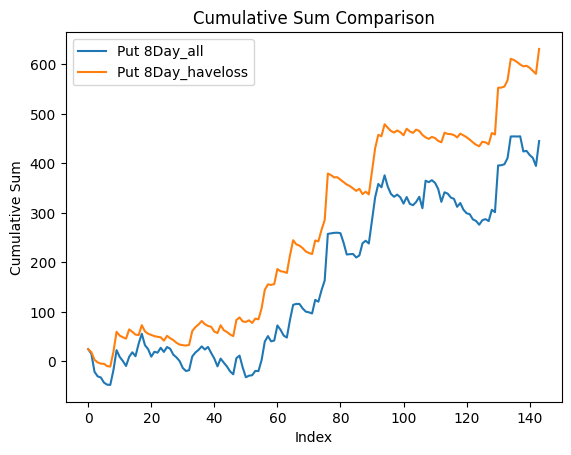

In [43]:
import matplotlib.pyplot as plt

# 繪製三條折線
new_stock_list['cumsum1'].plot(label='Put 8Day_all')
new_stock_list['cumsum2'].plot(label='Put 8Day_haveloss')

# 添加標題和圖例
plt.title('Cumulative Sum Comparison')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.legend()

# 顯示圖表
plt.show()
